# 条件随机场 (conditional random field)

## 前置知识

CRF是一种判别模型，利用条件概率图模型建模条件概率$P(Y|X)$完成判别任务。

也就是说，CRF是对一个条件概率进行估计。

利用吉布斯分布，CRF的具体形式可以表示为

$$P(Y|X)=\frac{1}{Z(X)}e^{-E(X)}$$

其中，$Z(X)$是归一化因子，$E(X)$是自定义的函数(势能函数)，包含状态函数和转移函数。

因此，CRF的训练目标就是得到合理的$E(X)$.

## CRF用于语义分割

### 动机

图像分割任务的核心目的在于对每个像素都分配一个标签。

然而，由于池化卷积的处理方式，导致目标区域的边缘存在较为模糊的地方。

那么就需要CRF为边缘提供新的信息，从而得到更好的边缘。

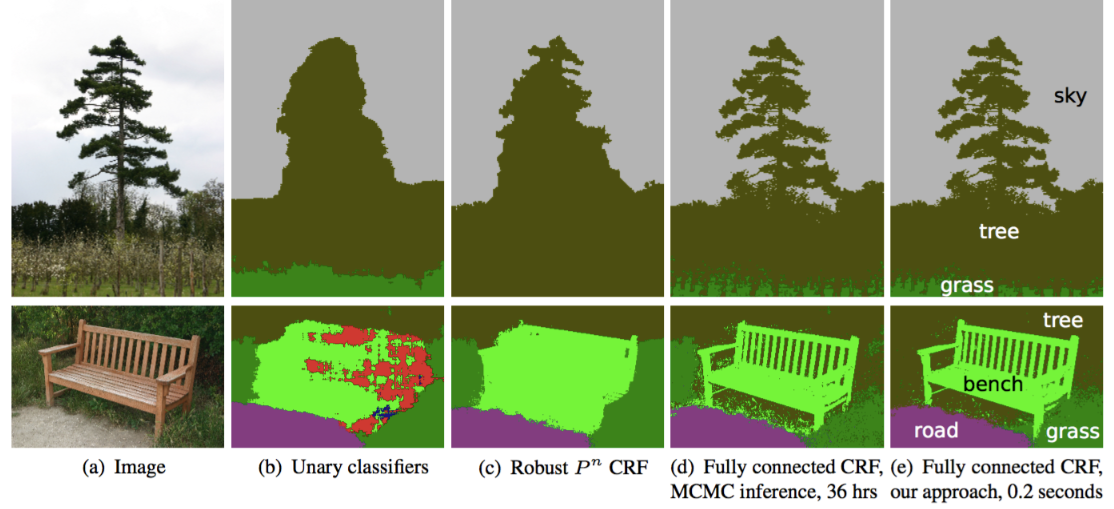

### 建立随机场

给定一张图像：

    * 定义 $X=\{X_1, X_2, ..., X_N\}$, 其中$X_i$为第i个像素的预测标签；
    * 定义 $L=\{L_1, L_2, ..., L_N\}$, 其中$L_i$为第i个像素的真实标签；
    * 定义 $I=\{I_1, I_2, ..., I_N\}$, 其中$I_i$为第i个像素数据。


那么图像分割任务则可表示为

$$P(X|I)=\frac{\exp(-E(X|I))}{Z(I)}$$

其中的关键在于如何定义势能函数。


此处以fully connected CRFs为例

$$E(X)=\sum_i \phi_u(x_i) + \sum_{i<j}\phi_p(x_i, x_j)$$

其中，第一项是CNN求解得到的粗略的值，可以对图像进行大致的分类。

第二项则是增量优化项，用于衡量$x_i, x_j$同时发生的概率。

简单来说，如果观测值$y_i, y_j$的相关性比较接近，则对应的像素的标签$x_i, x_j$应当属于同一类别(概率较大)

具体上，第二项的公式可以使用如下方法进行计算

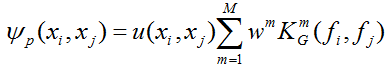

### 直观解释

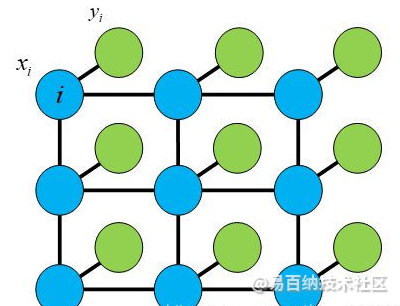

每个像素点(RGB为向量)可以作为观测值，我们需要根据观测值为每个像素点推测出一个标签。

因此，现在主流的语义分割模型，基本都是以下框架

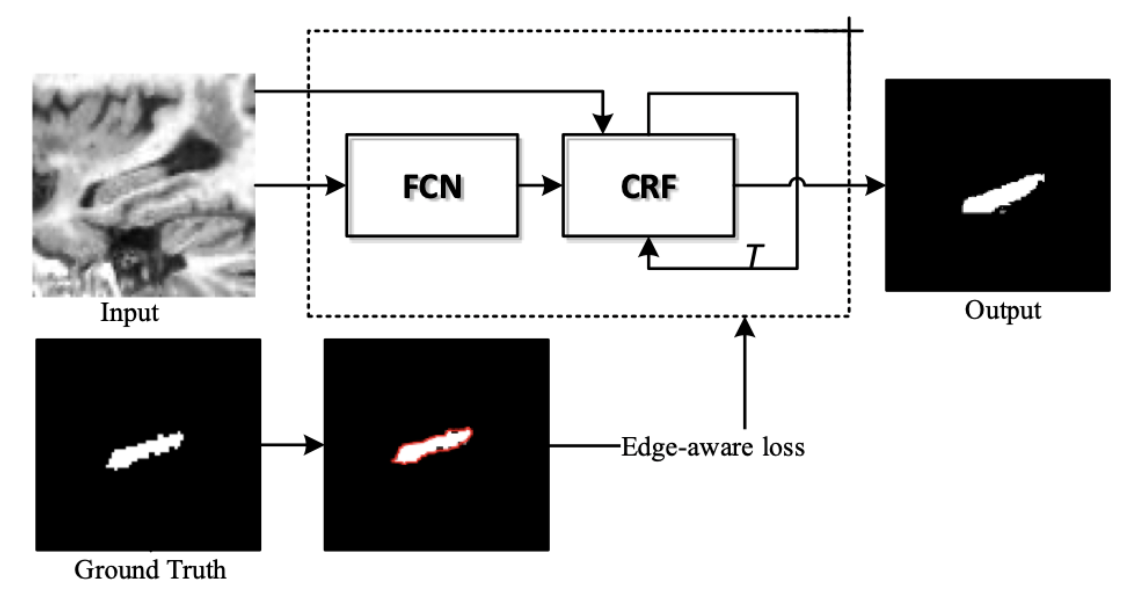

### 缺点

然而，这种方法存在一个比较大的问题，即**速度慢**

速度慢的原因，主要来自于CRF。

CRF的求解复杂度较高，因此需要更长的时间来优化结果。


### 解决方案

用训练的方式近似地求解CRF

也就是说，将CRF过程分解成一系列的卷积过程，用RNN的方式进行求解。

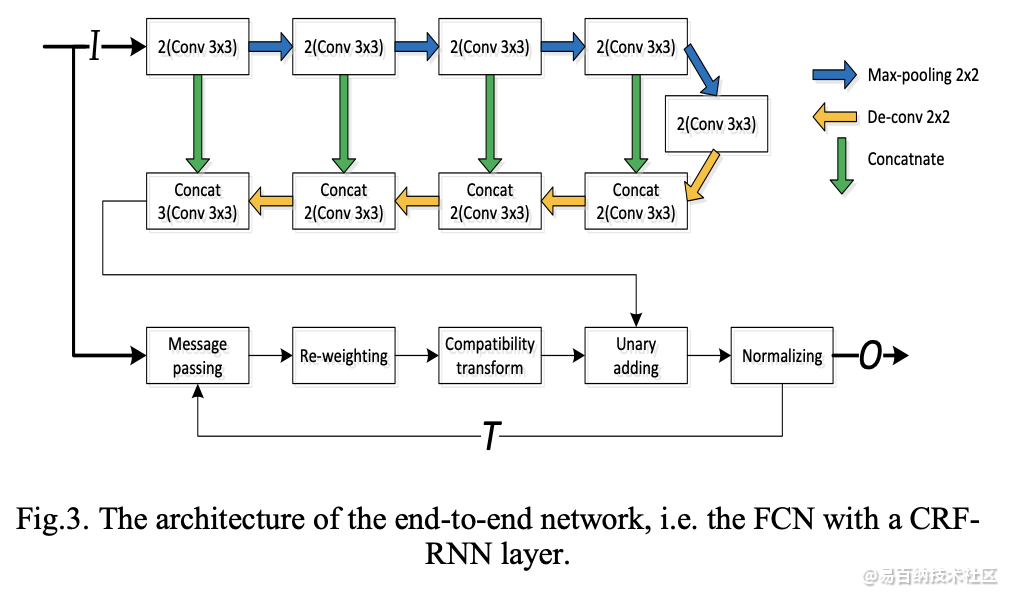

带入到图像中来，CRF的初始化结果可以由CNN直接给出，即$Q_i(l)$为FCN的feature map

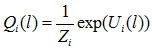

**step1**

首先看$Z_i$是一个归一化过程，可直接通过$softmax$完成；

**step2**

其次，message passing步骤中，是用m个高斯滤波器在Q上滤波实现的。

相当于对feature map进行模糊处理，等价于卷积操作。

得到如下结果

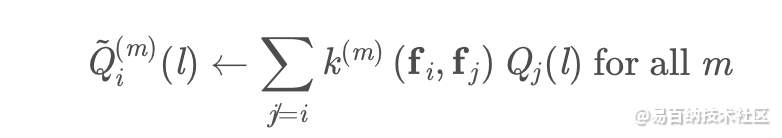

**step3**

第三步：compatibility transform

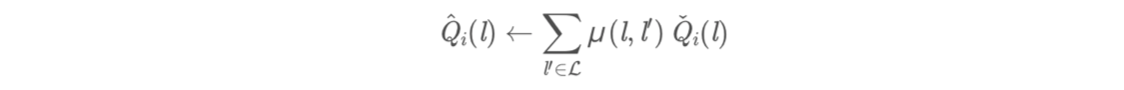

标签相似性函数$\mu(l, l')$表示了两个标签的相似性。

如果将不同的标签分配给相似特性的像素，则会造成较大的损失。

那么如何评判标签的相似度？

用$1\times1$的卷积，将l映射到l'，得到的参数即为$\mu$

**step4**

之后，进行unary potentials，即

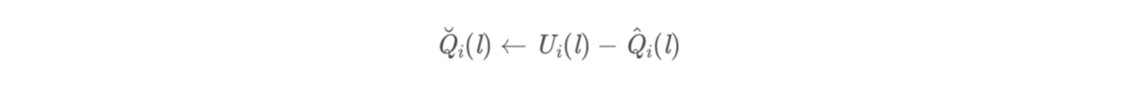

也就是将上次结果和这次结果的增量做对比。

最后，进行归一化，采用softmax实现。

### CRF as RNN

将上述视为一个RNN过程，对每一类的feature map都进行CRF处理，即可得到较优的结果。

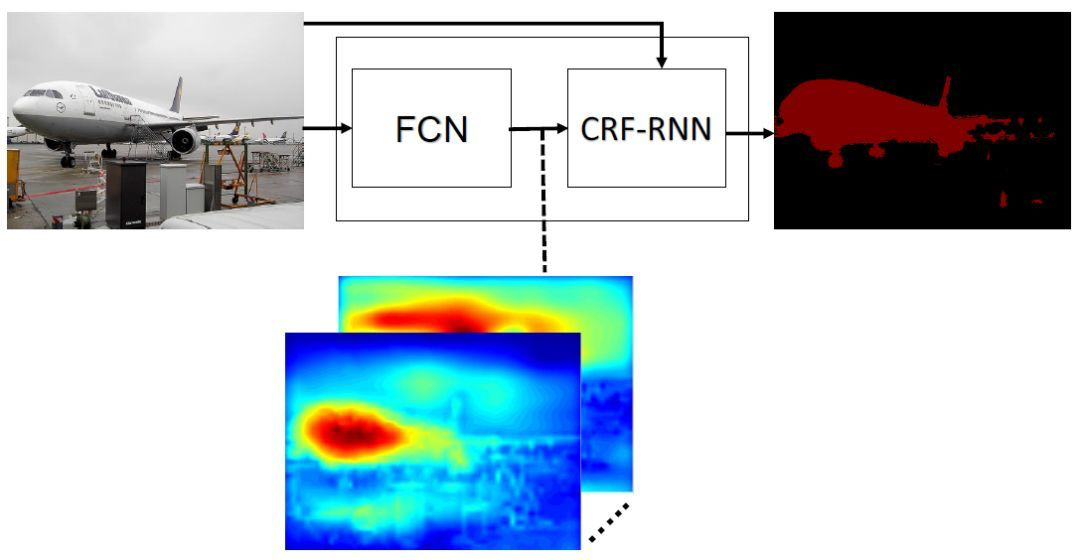

## 实现

[示例代码](https://github.com/sadeepj/crfasrnn_pytorch)